In [1]:
!pip install gTTS
!pip install google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1


In [2]:
from google.colab import files
files.upload()  # Upload Poppins-Regular.ttf and Poppins-Bold.ttf

Saving Poppins-Bold.ttf to Poppins-Bold.ttf
Saving Poppins-Regular.ttf to Poppins-Regular.ttf


{'Poppins-Bold.ttf': b'\x00\x01\x00\x00\x00\r\x00\x80\x00\x03\x00PGDEF\t\x16\t\x19\x00\x00\x01X\x00\x00\x00@GPOS\x19\xd8\x1b\xf6\x00\x00#\x10\x00\x00\x13\xccGSUBn\xa8\xac\x04\x00\x00Yt\x00\x00&xOS/2\xdb$z\xed\x00\x00\x01\x98\x00\x00\x00`cmap5\t;\x14\x00\x00\x01\xf8\x00\x00\x02\xd2glyf\xae\x92\xf9\x92\x00\x00\x7f\xec\x00\x01\xd9jhead\x1aQ$q\x00\x00\x01 \x00\x00\x006hhea\x0b\xfc\x05z\x00\x00\x00\xfc\x00\x00\x00$hmtx\xbe\xb8\xed\xa6\x00\x00\x12\x84\x00\x00\x10\x8aloca\xf6Mh\x8b\x00\x00\n<\x00\x00\x08Hmaxp\x04\xa5\x01%\x00\x00\x00\xdc\x00\x00\x00 name\xb7\xf1\x12\x12\x00\x00\x04\xcc\x00\x00\x05ppost:\xbfh\x9b\x00\x006\xdc\x00\x00"\x95\x00\x01\x00\x00\x04#\x00\x90\x00\x0c\x00t\x00\x06\x00\x01\x00\x02\x00\x1e\x00\x06\x00\x00\x00d\x00\x00\x00\x03\x00\x02\x00\x01\x00\x00\x04\x1a\xfe\xa2\x00d\t\x9d\xfd\xce\xf9\x18\t\xad\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04"\x00\x01\x00\x00\x00\x04\x01\x06\x89\xa9\x14\xcf_\x0f<\xf5\x00\x03\x03\xe8\x00\x00\x00\x00\xd8\xa4\xa9\xc8\x0

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-28 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


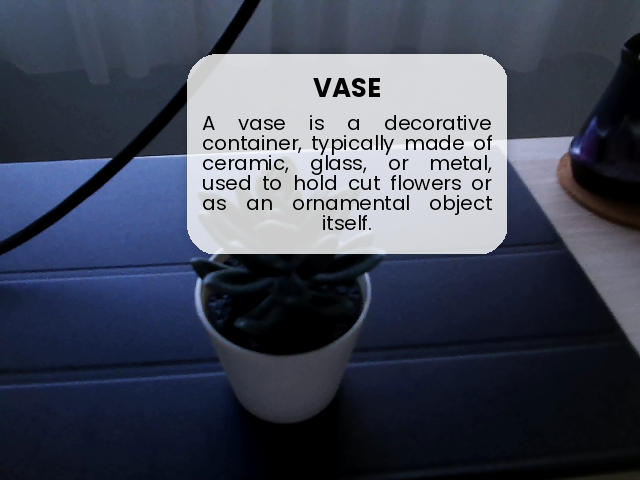

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


KeyboardInterrupt: 

In [5]:
import cv2
import torch
import numpy as np
import base64
import requests
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from IPython.display import display, clear_output, Audio
from google.colab.output import eval_js
from base64 import b64decode
import os
import time
from gtts import gTTS
import tempfile
import google.generativeai as genai
import requests
import json
import textwrap
import time
from IPython.display import Audio, display, clear_output

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY") or "YOUR_GEMINI_API_KEY"

FALLBACK_DESCRIPTIONS = {
    "person": "A human being.",
    "dog": "A domesticated carnivorous mammal, often kept as a pet.",
    "cat": "A small furry carnivorous mammal, commonly kept as a pet.",
    "car": "A wheeled motor vehicle used for transportation.",
}

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model.conf = 0.5  # Confidence threshold

desc_cache = {}
spoken_cache = set()

# Fonts
def get_font(size, bold=False):
    try:
        path = "Poppins-Bold.ttf" if bold else "Poppins-Regular.ttf"
        return ImageFont.truetype(path, size)
    except:
        return ImageFont.load_default()

def get_description(label, cropped_image=None):
    if label in desc_cache:
        return desc_cache[label]

    try:
        url = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?key={GEMINI_API_KEY}"
        headers = {'Content-Type': 'application/json'}
        prompt = f"Give a brief educational description of a {label} for an AR learning app. Go straight to the answer and keep it short in 1 sentence."

        payload = {
            "contents": [
                {
                    "parts": [{"text": prompt}]
                }
            ]
        }

        response = requests.post(url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()
        data = response.json()

        desc = data["candidates"][0]["content"]["parts"][0]["text"].strip()
        desc_cache[label] = desc
        return desc

    except Exception as e:
        print(f"[Gemini Error] {e}")
        fallback = FALLBACK_DESCRIPTIONS.get(label, f"A {label} is commonly found in daily life.")
        desc_cache[label] = fallback
        return fallback

def capture_frame():
    js = """
    async function capture() {
        const video = document.createElement('video');
        video.style.display = 'none';
        document.body.appendChild(video);

        const stream = await navigator.mediaDevices.getUserMedia({video: {width: 640, height: 480}});
        video.srcObject = stream;
        await video.play();

        const canvas = document.createElement('canvas');
        canvas.width = 640;
        canvas.height = 480;
        canvas.getContext('2d').drawImage(video, 0, 0, canvas.width, canvas.height);

        stream.getTracks().forEach(track => track.stop());
        video.remove();

        return canvas.toDataURL('image/png');
    }
    capture();
    """
    data_url = eval_js(js)
    header, encoded = data_url.split(',', 1)
    img_bytes = b64decode(encoded)
    np_arr = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    return img

def speak_text(text):
    with tempfile.NamedTemporaryFile(delete=True, suffix=".mp3") as fp:
        tts = gTTS(text=text, lang='en')
        tts.save(fp.name)
        audio = Audio(fp.name, autoplay=True)
        display(audio)
        # Wait estimation: average 150 words/minute ~ 0.4 sec per word
        wait_time = max(2, len(text.split()) * 0.4)
        time.sleep(wait_time)
        clear_output(wait=True)

def render_styled_overlay(frame, row):
    from PIL import Image, ImageDraw, ImageFont, ImageFilter

    def wrap_text_to_fit(text, font, max_width):
        words = text.split()
        lines, line = [], ""
        for word in words:
            test_line = f"{line} {word}".strip()
            width = font.getbbox(test_line)[2]
            if width <= max_width:
                line = test_line
            else:
                lines.append(line)
                line = word
        if line:
            lines.append(line)
        return lines

    def draw_justified_text(draw, text_lines, font, box_x, box_y, box_w, line_height, color, line_spacing=6):
        for i, line in enumerate(text_lines):
            words = line.split()
            if len(words) == 1 or i == len(text_lines) - 1:
                text_width = font.getbbox(line)[2]
                draw.text(((box_x + box_w / 2) - text_width / 2, box_y), line, font=font, fill=color)
            else:
                line_width = sum([font.getbbox(w)[2] for w in words])
                space_total = box_w - line_width
                n_spaces = len(words) - 1
                space_width = space_total // n_spaces if n_spaces > 0 else 0
                extra_space = space_total % n_spaces

                x = box_x
                for j, word in enumerate(words):
                    draw.text((x, box_y), word, font=font, fill=color)
                    word_width = font.getbbox(word)[2]
                    x += word_width + space_width
                    if j < extra_space:
                        x += 1
            box_y += line_height + line_spacing

    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA))
    overlay = Image.new("RGBA", img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    text_color = (0, 0, 0, 255)
    box = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])]
    cropped_img = frame[box[1]:box[3], box[0]:box[2]]
    label = row['name']
    desc = get_description(label, cropped_img)

    # Card specs
    card_w, card_h = 320, 200  # Add extra height
    card_x = max(10, box[0])
    card_y = box[1] - card_h - 10 if box[1] - card_h - 10 > 0 else box[3] + 10
    card_x = min(card_x, img.width - card_w - 10)

    # Shadow
    shadow = Image.new("RGBA", (card_w + 20, card_h + 20), (0, 0, 0, 0))
    shadow_draw = ImageDraw.Draw(shadow)
    shadow_draw.rounded_rectangle([10, 10, card_w + 10, card_h + 10], radius=30, fill=(0, 0, 0, 180))
    shadow = shadow.filter(ImageFilter.GaussianBlur(8))
    overlay.paste(shadow, (card_x - 10, card_y - 10), shadow)

    # Card background with 80% opacity
    card = Image.new("RGBA", (card_w, card_h), (255, 255, 255, int(255 * 0.8)))
    mask = Image.new("L", (card_w, card_h), 0)
    mask_draw = ImageDraw.Draw(mask)
    mask_draw.rounded_rectangle([0, 0, card_w, card_h], radius=30, fill=255)
    overlay.paste(card, (card_x, card_y), mask)

    # Title
    font_title = get_font(26, bold=True)
    title = label.upper()
    title_w = font_title.getbbox(title)[2]
    draw.text(
        ((card_x + card_w / 2) - title_w / 2, card_y + 15),
        title,
        font=font_title,
        fill=text_color
    )

    # Description
    max_width = card_w - 30
    max_height = card_h - 70  # Adjusted height
    base_font_size = 20
    font_desc = get_font(base_font_size)
    wrapped_lines = wrap_text_to_fit(desc, font_desc, max_width)
    line_height = font_desc.getbbox("A")[3] - font_desc.getbbox("A")[1]
    total_height = len(wrapped_lines) * (line_height + 6)

    while total_height > max_height and base_font_size > 10:
        base_font_size -= 1
        font_desc = get_font(base_font_size)
        wrapped_lines = wrap_text_to_fit(desc, font_desc, max_width)
        line_height = font_desc.getbbox("A")[3] - font_desc.getbbox("A")[1]
        total_height = len(wrapped_lines) * (line_height + 6)

    # Justified multiline description
    draw_justified_text(
        draw=draw,
        text_lines=wrapped_lines,
        font=font_desc,
        box_x=card_x + 15,
        box_y=card_y + 55,
        box_w=max_width,
        line_height=line_height,
        color=text_color
    )

    return Image.alpha_composite(img, overlay), desc

def run_realtime_ar(duration=30, fps=5):
    from IPython.display import display, update_display, clear_output
    from PIL import Image

    display_handle = display("", display_id=True)
    interval = 1.0 / fps
    start = time.time()
    last_desc = None

    while (time.time() - start) < duration:
        try:
            # 1. Capture webcam frame
            frame = capture_frame()

            # 2. Run YOLOv5 object detection
            results = model(frame)
            df = results.pandas().xyxy[0]

            # 3. If any objects found, render overlay
            if not df.empty:
                top = df.sort_values(by='confidence', ascending=False).iloc[0]
                styled_img, desc = render_styled_overlay(frame, top)
                display_handle.update(styled_img)

                # Speak only new descriptions
                if desc != last_desc:
                    if desc not in spoken_cache:
                        speak_text(desc)
                        spoken_cache.add(desc)
                    last_desc = desc
            else:
                # Show just raw webcam feed
                display_handle.update(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

            time.sleep(interval)

        except Exception as e:
            print(f"[Error in AR loop]: {e}")
            break

# Run the app
run_realtime_ar(duration=30, fps=5)